# Volatility modeling

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt

In [3]:
import statsmodels.api as sm

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

# This code will supress certain unnecessary warnings from the statsmodels package
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.filterwarnings('ignore', module='statsmodels', category=FutureWarning)
warnings.filterwarnings('ignore', module='statsmodels', category=ValueWarning)

We'll be using the `arch` [package](https://pypi.org/project/arch/), so be sure to have that installed.

In [4]:
from arch import arch_model
from arch.univariate import ARX, GARCH, EGARCH, ConstantMean, StudentsT, SkewStudent

In [12]:
spy = pdr.get_data_yahoo('SPY', 1995, 2022)

spy = spy['Adj Close'].pct_change().dropna()

spy.name = 'ret'

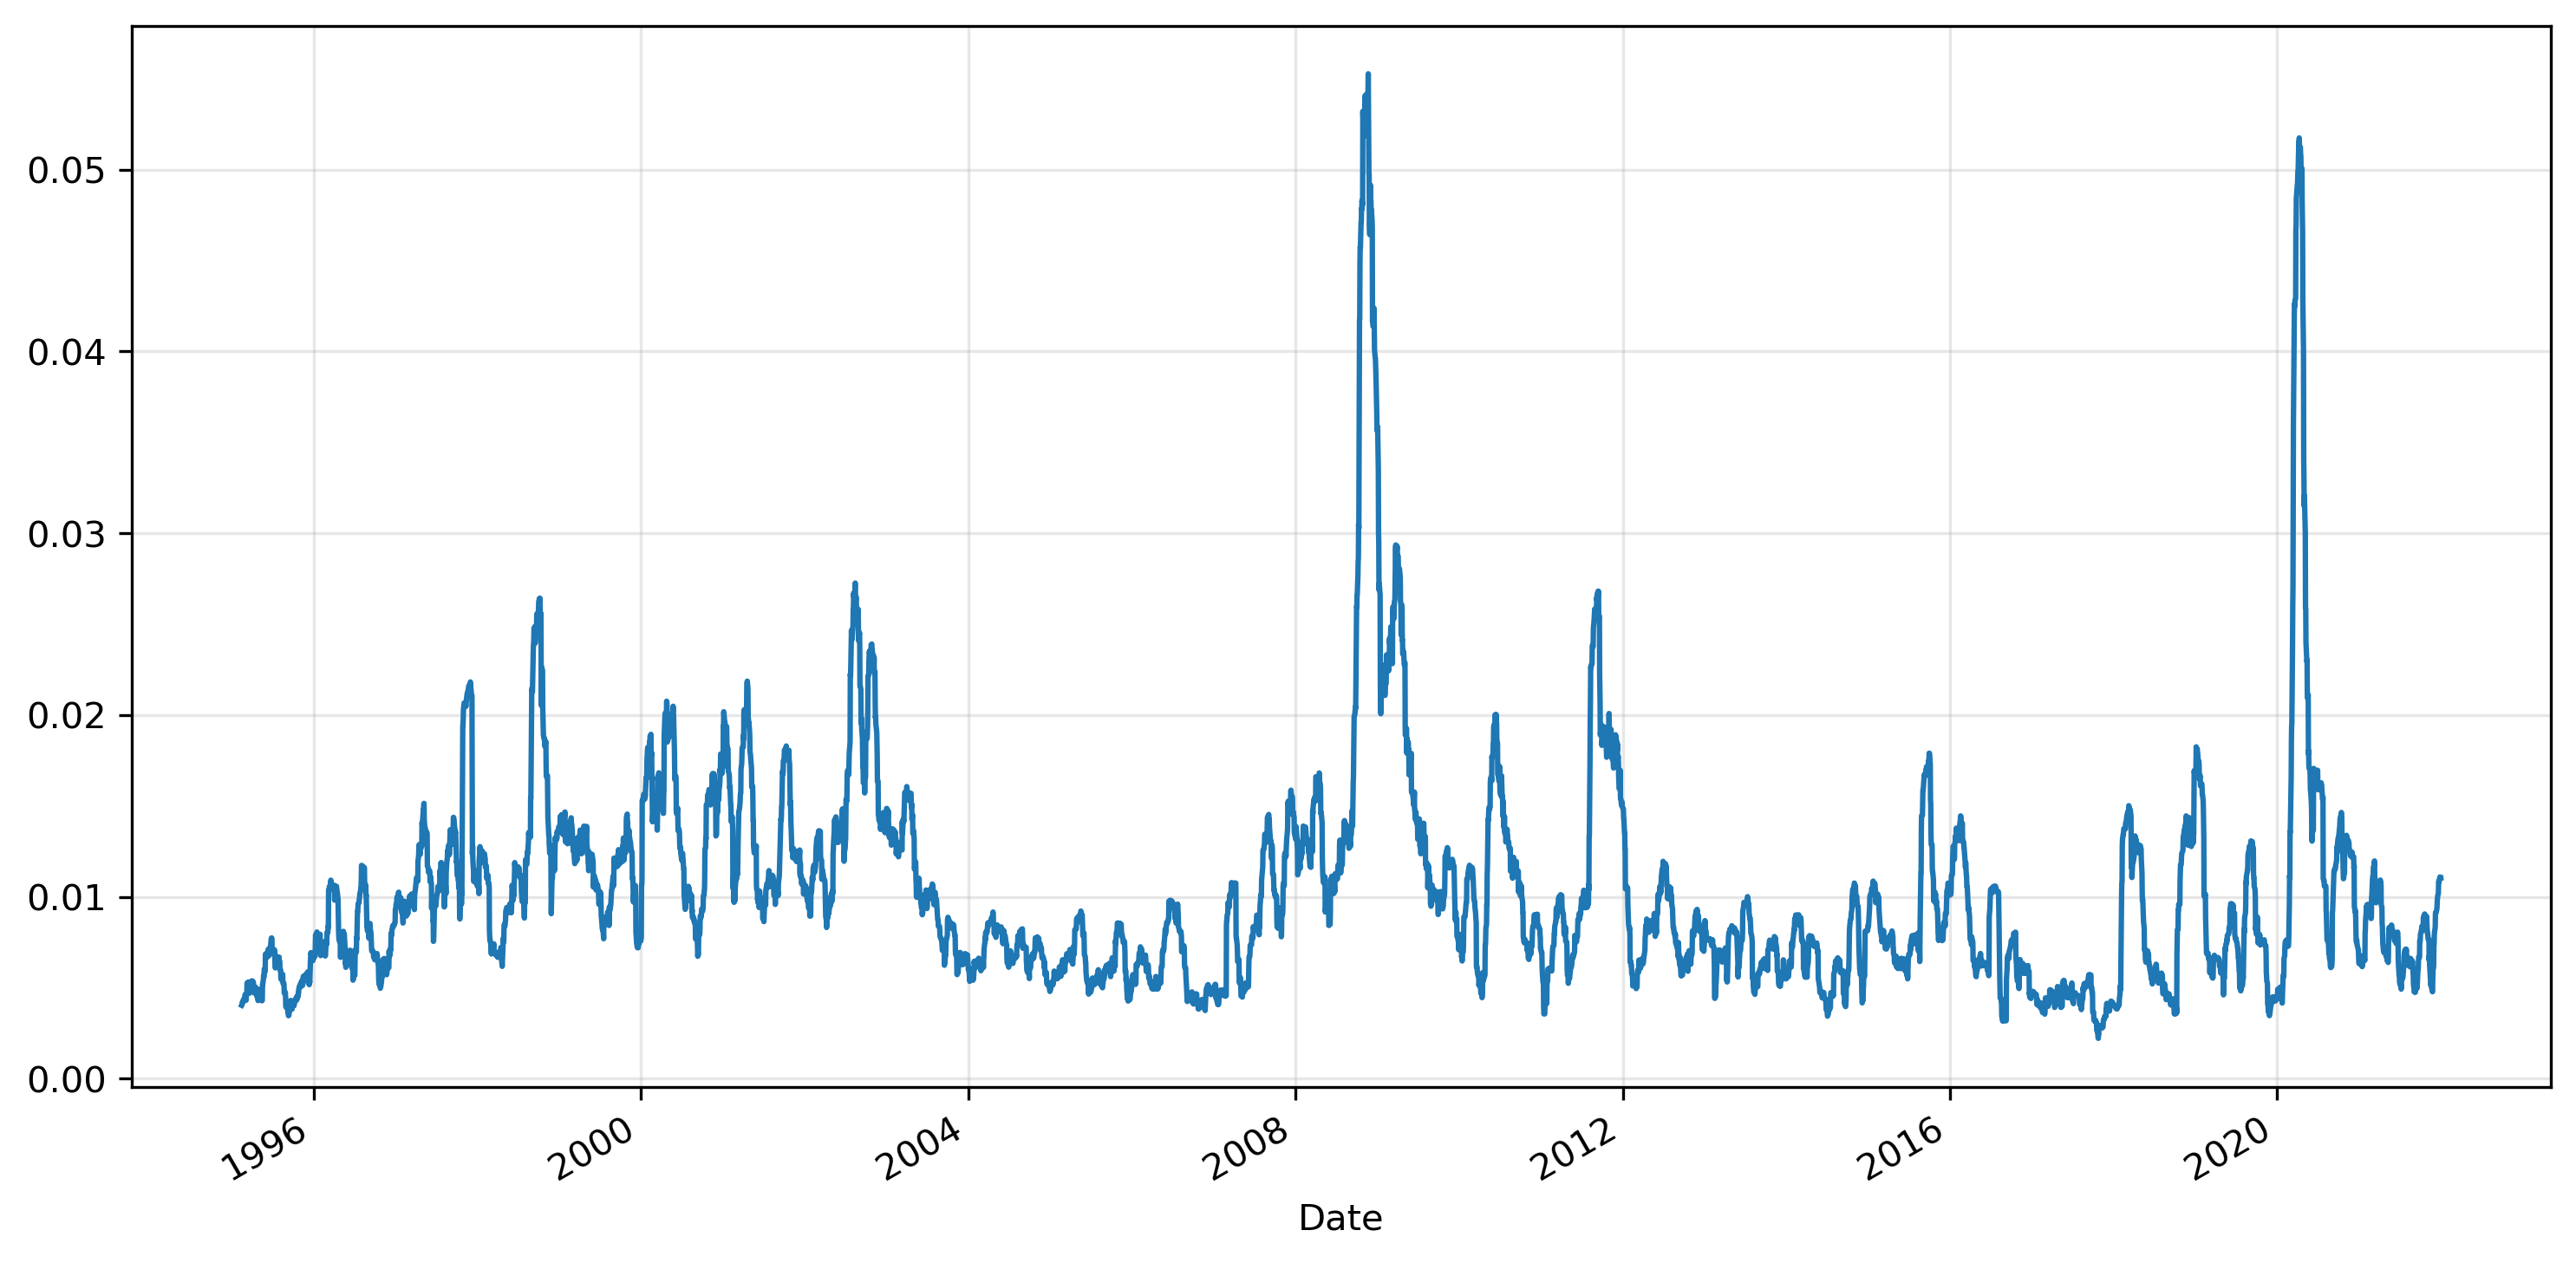

In [13]:
spy.rolling(30).std().plot(grid=True);

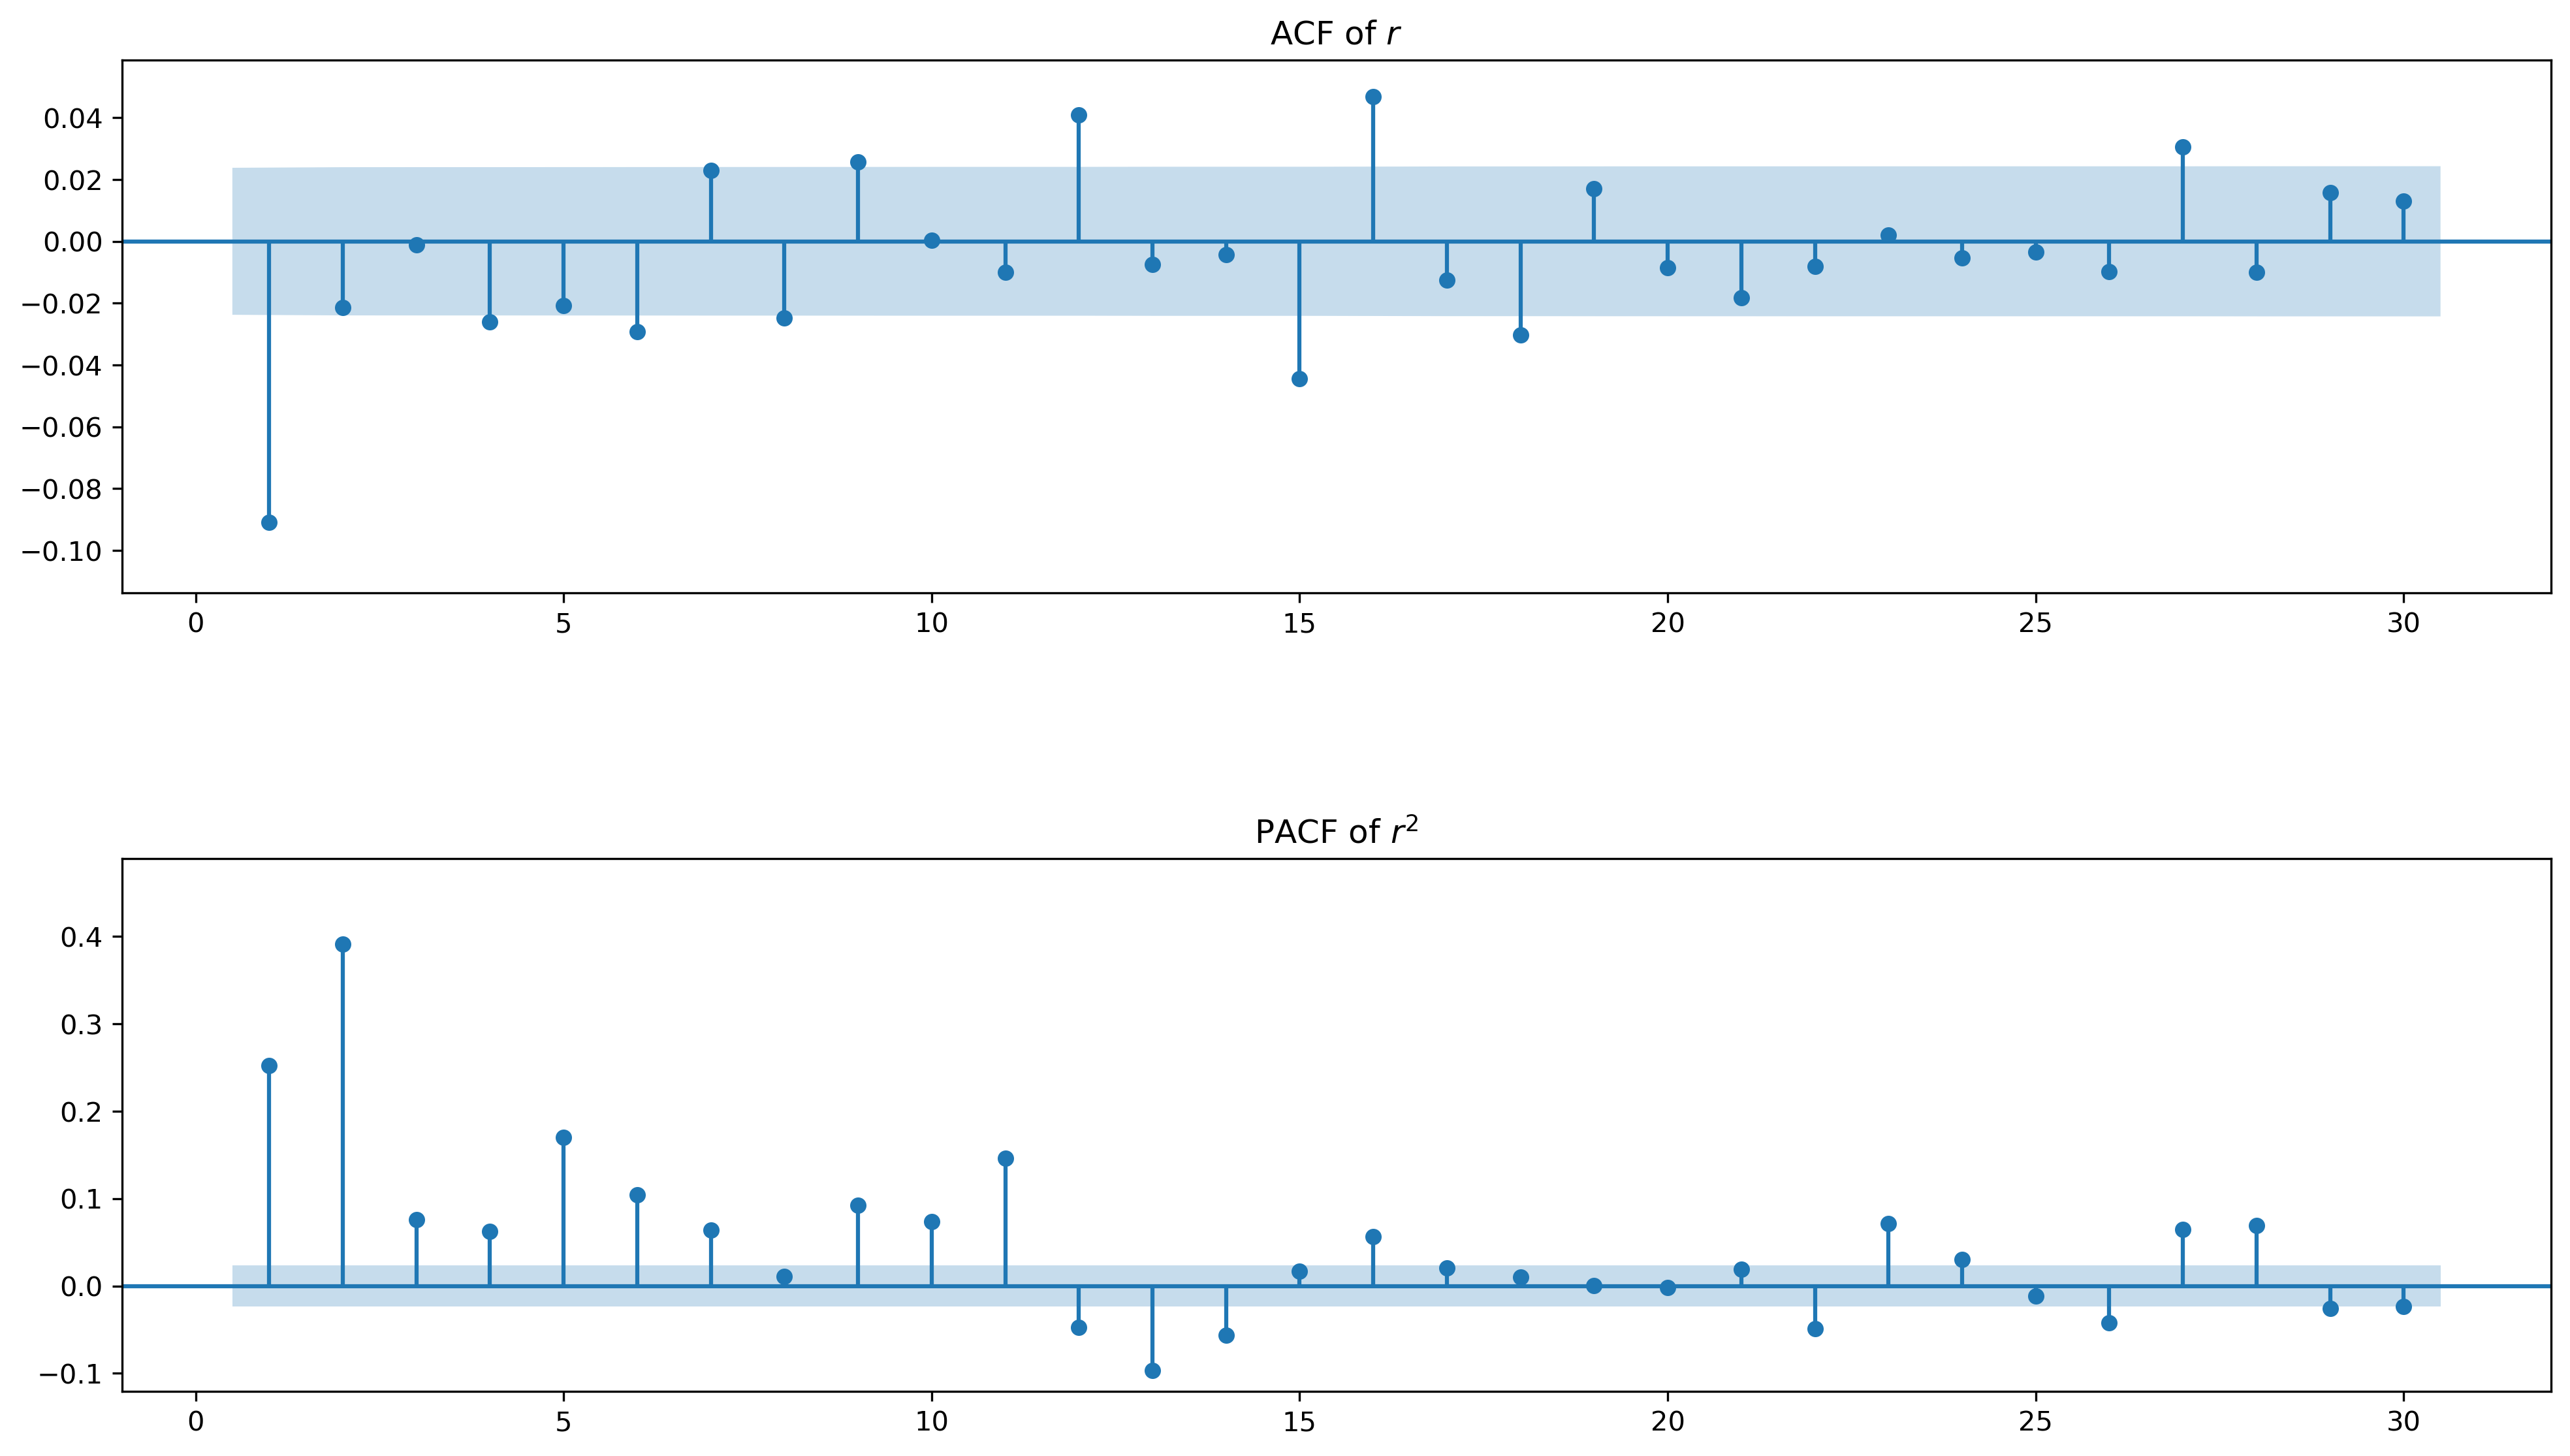

In [14]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,9))

fig = sm.graphics.tsa.plot_acf(spy, lags=30, zero=False, auto_ylims=True, ax=ax1)
ax1.set_title('ACF of $r$')

fig = sm.graphics.tsa.plot_pacf(spy**2, lags=30, ax=ax2, zero=False, auto_ylims=True)
ax2.set_title('PACF of $r^2$')

plt.subplots_adjust(hspace=0.5)
plt.show()

## GARCH

If we specify an ARMA model for $\sigma^2$, the model is called a generalized autoregressive conditional heteroskedasticity (GARCH) model.


$$ r_t  =  \mu + \varepsilon_t, \quad \varepsilon_t  =  \sigma_t e_t,$$

$$\sigma^2_t   =  \omega + \alpha \varepsilon_{t-1}^2 + \beta \sigma_{t-1}^2,$$

$$e_t  \sim  N(0,1).$$

Notice that as $\sigma_t$ changes, the volatility of $\varepsilon_t$ changes. Obviously, if $\sigma_t=1$ then $\varepsilon_t=e_t$ has a variance of 1. But suppose that $\sigma_t=1.5$. Now

$$\var(\varepsilon_t) = \var(1.5\times e_t) = 1.5^2 \times \var(e_t) = 1.5^2,$$

so the volatility of $\varepsilon_t$ is 1.5. In other words, the volatility of the noise term is controlled entirely by $\sigma_t$, which we allow to vary over time.

More generally, a GARCH($p,q$) model specifies a variance of

$$\sigma_t^2 = \omega +\sum_{i=1}^{q}\alpha_i\varepsilon_{t-i}^{2}+\sum _{i=1}^{p}\beta_i\sigma _{t-i}^{2}.$$

In [15]:
# scaling helps with log-likelihood maximization
spy = spy*100

In [16]:
mod1 = ConstantMean(spy)
mod1.volatility = GARCH(p=1,q=1)
res1 = mod1.fit(disp='on')
print(res1.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1645953742.754961
Iteration:      2,   Func. Count:     15,   Neg. LLF: 3805736125.047031
Iteration:      3,   Func. Count:     22,   Neg. LLF: 12942.908506348966
Iteration:      4,   Func. Count:     29,   Neg. LLF: 9506.552460357936
Iteration:      5,   Func. Count:     35,   Neg. LLF: 9361.76331879045
Iteration:      6,   Func. Count:     41,   Neg. LLF: 9676.768033278962
Iteration:      7,   Func. Count:     47,   Neg. LLF: 9386.351177653953
Iteration:      8,   Func. Count:     53,   Neg. LLF: 9328.426692438145
Iteration:      9,   Func. Count:     58,   Neg. LLF: 9328.24299955133
Iteration:     10,   Func. Count:     63,   Neg. LLF: 9328.241630273564
Iteration:     11,   Func. Count:     68,   Neg. LLF: 9328.241626589304
Iteration:     12,   Func. Count:     72,   Neg. LLF: 9328.24162659041
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    ret   R-squared:         

The estimated model is

$$r_t = 0.0815 + \varepsilon_t,$$

$$\sigma_t^2 = 0.0229 + 0.1231 \varepsilon_{t-1}^2 + 0.8617 \sigma_{t-1}^2.$$

Notice that $\alpha+\beta \approx 1$. This is commonly observed with financial data, and the related *IGARCH* model requires $\alpha+\beta=1$ as a constraint in the estimation.

In [17]:
res1.params

mu          0.081452
omega       0.022903
alpha[1]    0.123144
beta[1]     0.861669
Name: params, dtype: float64

The *conditional volatility* is the estimate of the time series of $\sigma^2$.

In [18]:
res1.conditional_volatility

Date
1995-01-04    0.444635
1995-01-05    0.461084
1995-01-06    0.454873
1995-01-09    0.448599
1995-01-10    0.443122
                ...   
2021-12-27    1.126419
2021-12-28    1.155539
2021-12-29    1.084778
2021-12-30    1.018397
2021-12-31    0.965578
Name: cond_vol, Length: 6798, dtype: float64

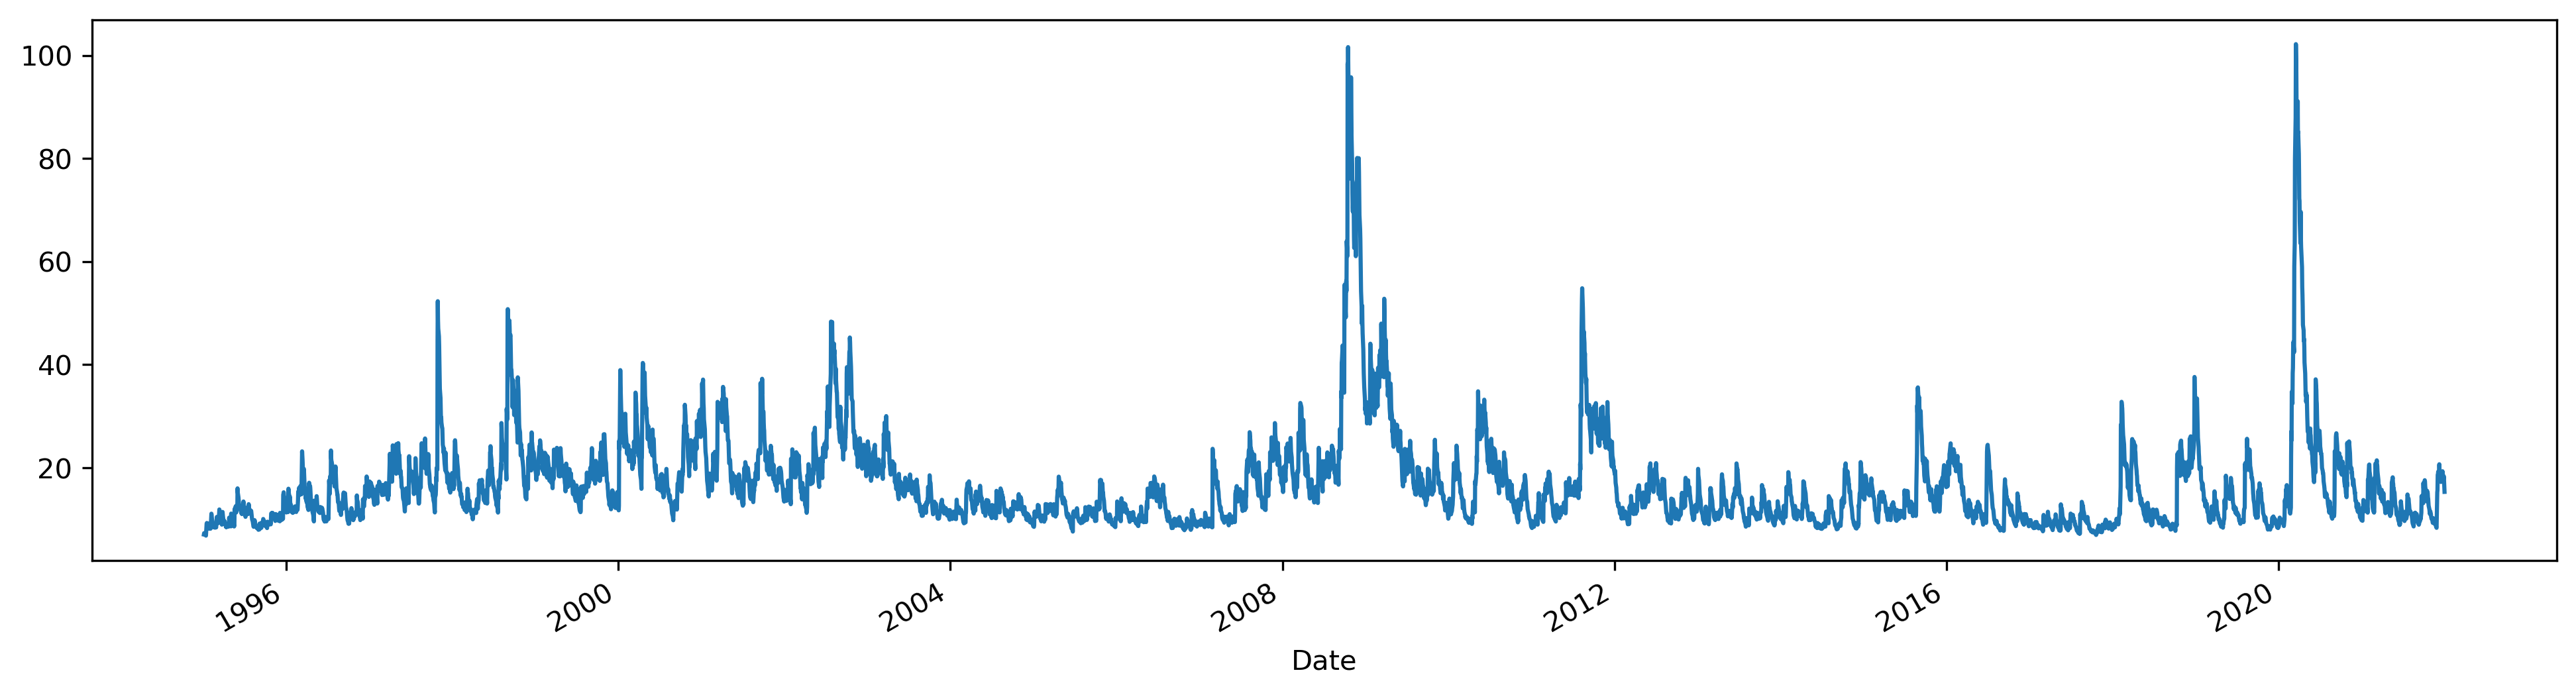

In [21]:
# Annualized volatility
(res1.conditional_volatility * np.sqrt(252)).plot(figsize=(16,4));

In [23]:
#  Standardized residuals
std_resid = res1.resid / res1.conditional_volatility

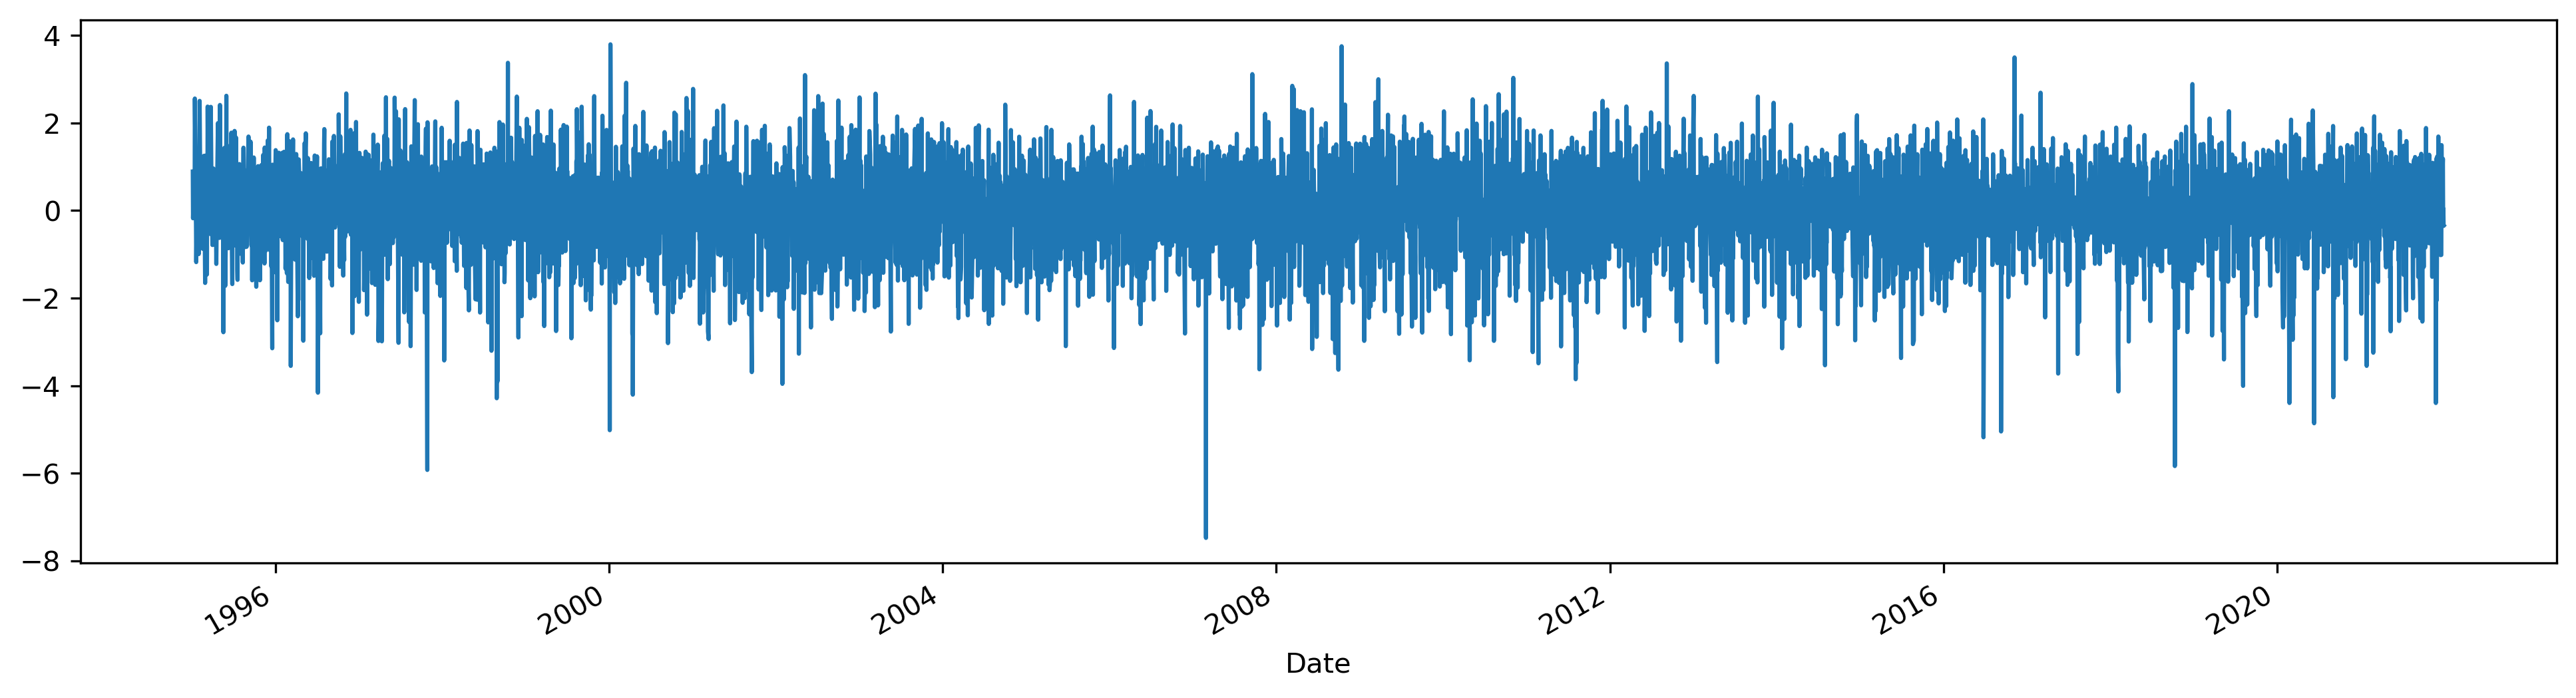

In [24]:
std_resid.plot(figsize=(16,4));

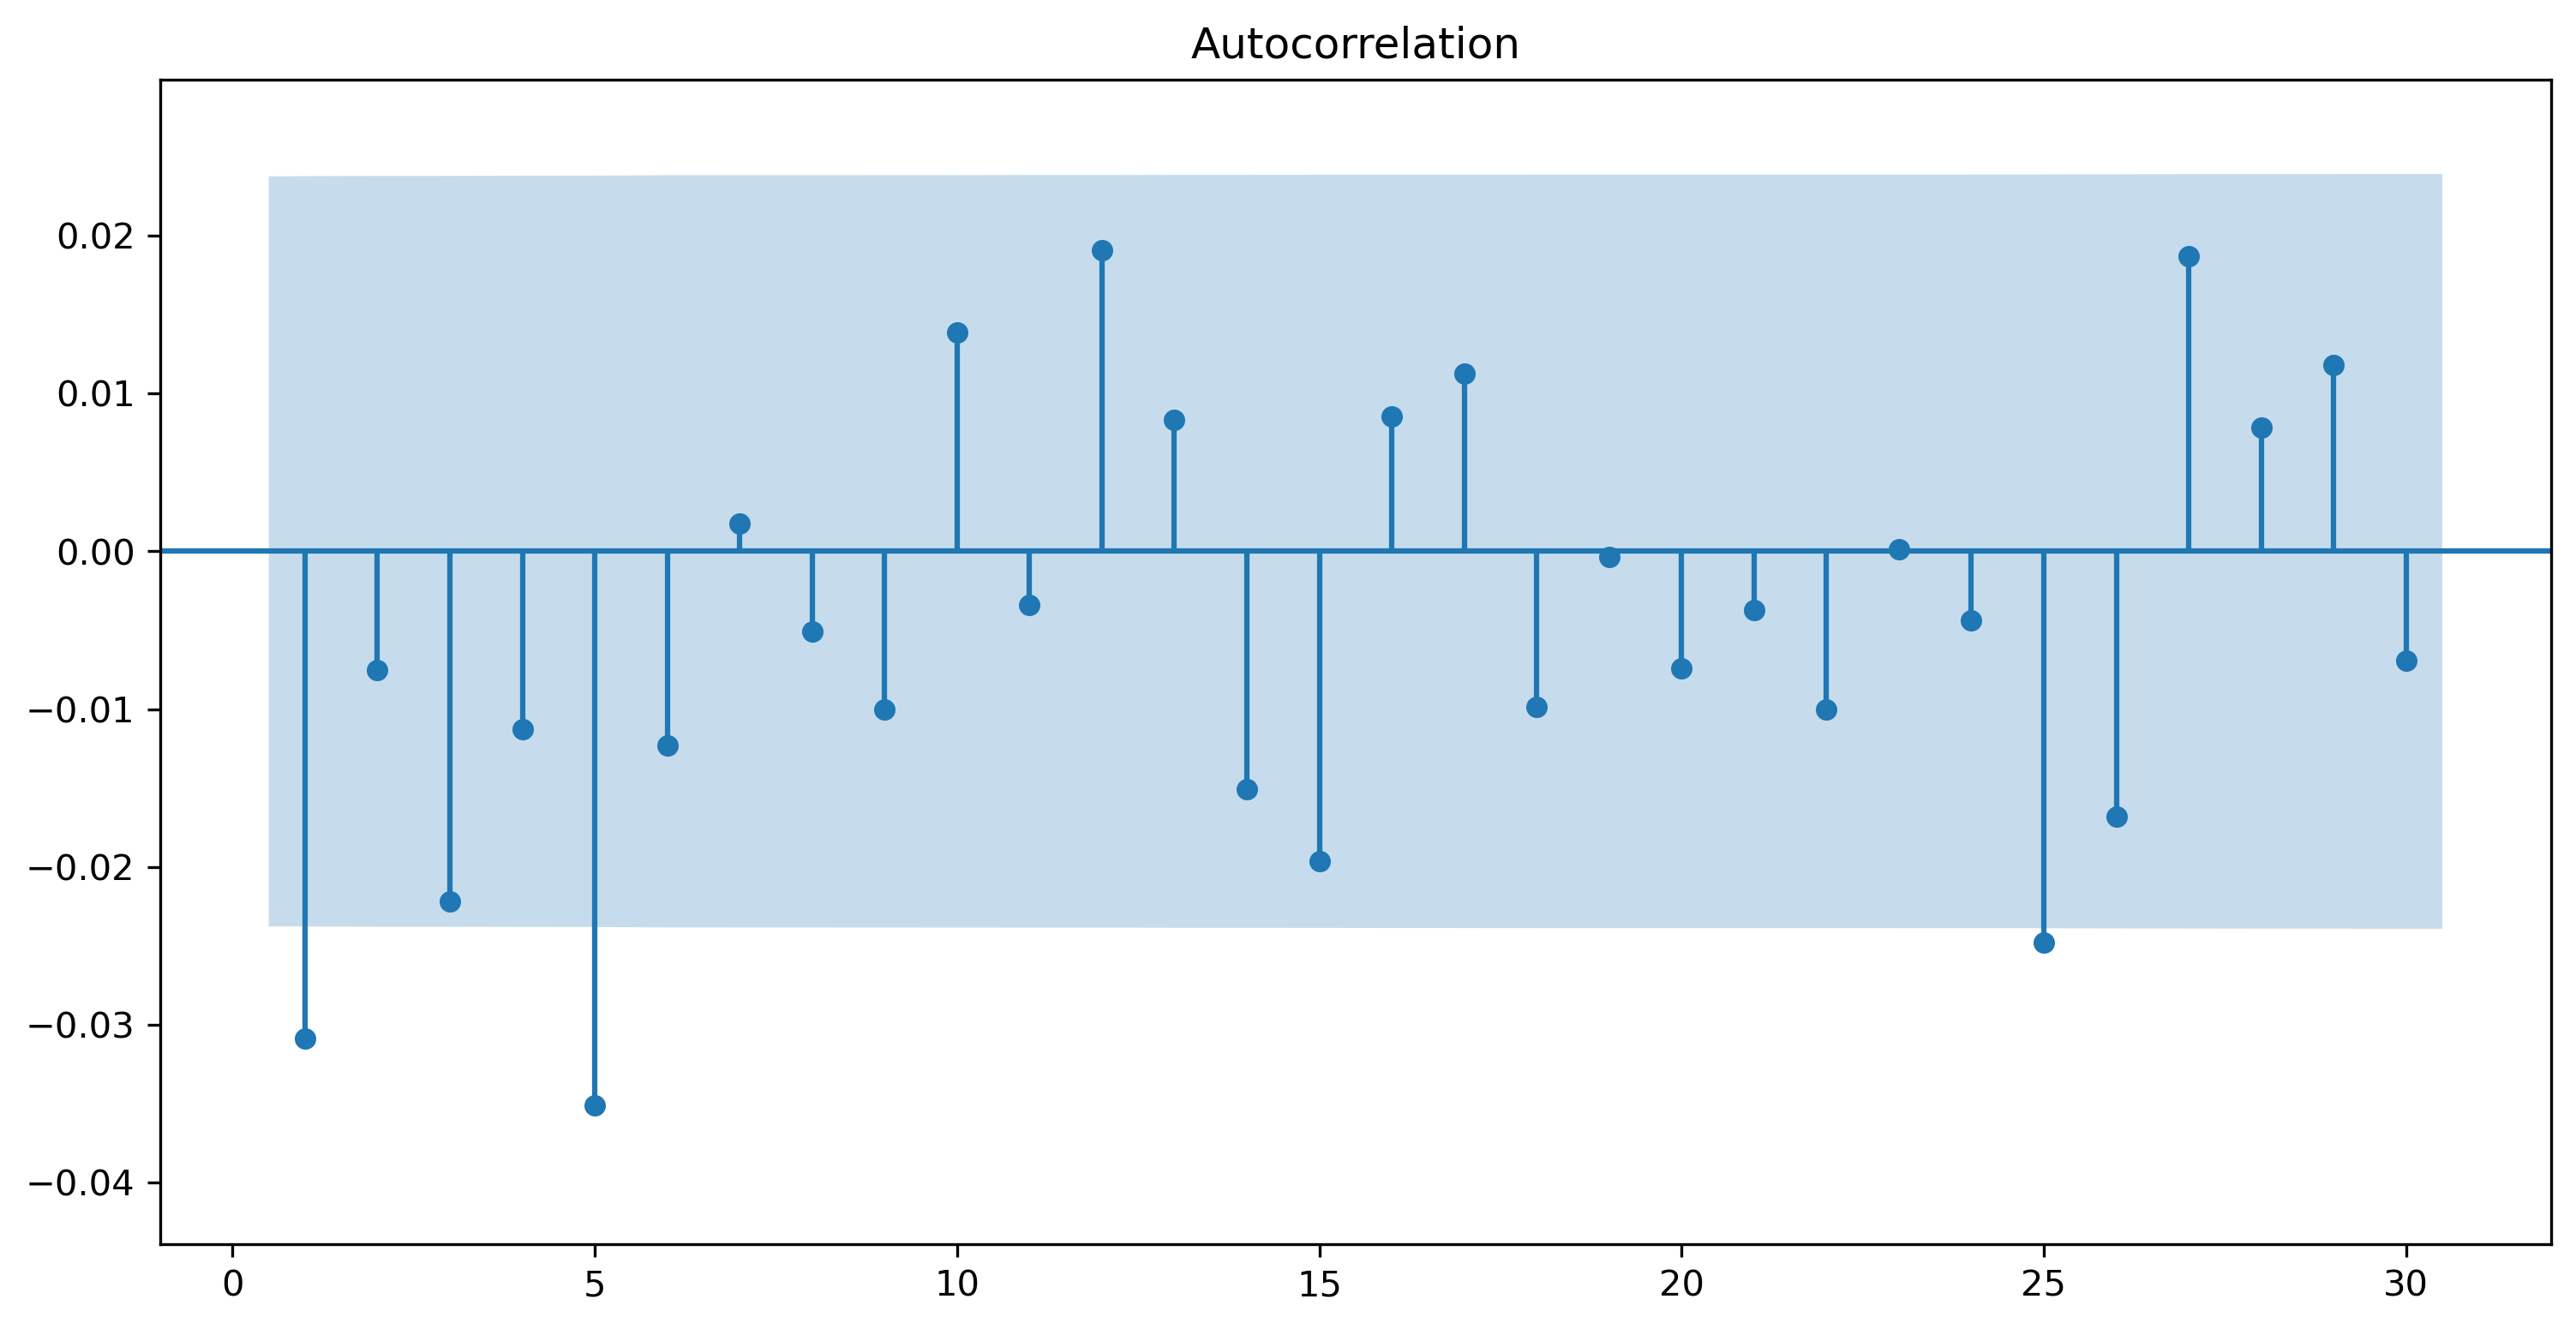

In [25]:
fig = sm.graphics.tsa.plot_acf(std_resid.values, lags=30, zero=False, auto_ylims=True)

We don't have to assume a constant mean for the return process. Instead, we can combine an AR process in the return with GARCH volatility. For example, we can fit an AR(3) model to the data. We'll start with just an AR(3), and then add in the GARCH process for the volatility.

In [26]:
# AR(3)
ar3 = ARIMA(spy, order=(3,0,0)).fit()
print(ar3.summary())

                               SARIMAX Results                                
Dep. Variable:                    ret   No. Observations:                 6798
Model:                 ARIMA(3, 0, 0)   Log Likelihood              -10905.486
Date:                Mon, 11 Apr 2022   AIC                          21820.971
Time:                        11:20:29   BIC                          21855.093
Sample:                             0   HQIC                         21832.747
                               - 6798                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0489      0.014      3.541      0.000       0.022       0.076
ar.L1         -0.0938      0.006    -14.585      0.000      -0.106      -0.081
ar.L2         -0.0305      0.005     -6.105      0.0

In [27]:
mod2 = ARX(spy, lags=3)
mod2.volatility = GARCH(p=1,q=1)
res2 = mod2.fit(disp='off')
print(res2.summary())

                           AR - GARCH Model Results                           
Dep. Variable:                    ret   R-squared:                       0.005
Mean Model:                        AR   Adj. R-squared:                  0.005
Vol Model:                      GARCH   Log-Likelihood:               -9317.94
Distribution:                  Normal   AIC:                           18649.9
Method:            Maximum Likelihood   BIC:                           18697.6
                                        No. Observations:                 6795
Date:                Mon, Apr 11 2022   Df Residuals:                     6791
Time:                        11:20:41   Df Model:                            4
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
Const          0.0891  1.041e-02      8.562  1.112e-

In a model with $k$ lags of the time series, the conditional volatility will be missing for $k$ periods.

In [28]:
res2.conditional_volatility

Date
1995-01-04         NaN
1995-01-05         NaN
1995-01-06         NaN
1995-01-09    0.480336
1995-01-10    0.471049
                ...   
2021-12-27    1.122058
2021-12-28    1.164854
2021-12-29    1.092453
2021-12-30    1.026000
2021-12-31    0.971042
Name: cond_vol, Length: 6798, dtype: float64

We can “prune” the model by dropping insignificant parameters. 

In [29]:
mod2 = ARX(spy, lags=[1,3])
mod2.volatility = GARCH(p=1,q=1)
res2 = mod2.fit(disp='off')
print(res2.summary())

                           AR - GARCH Model Results                           
Dep. Variable:                    ret   R-squared:                       0.005
Mean Model:                        AR   Adj. R-squared:                  0.004
Vol Model:                      GARCH   Log-Likelihood:               -9318.51
Distribution:                  Normal   AIC:                           18649.0
Method:            Maximum Likelihood   BIC:                           18690.0
                                        No. Observations:                 6795
Date:                Mon, Apr 11 2022   Df Residuals:                     6792
Time:                        11:24:03   Df Model:                            3
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
Const          0.0880  1.018e-02      8.638  5.728e-

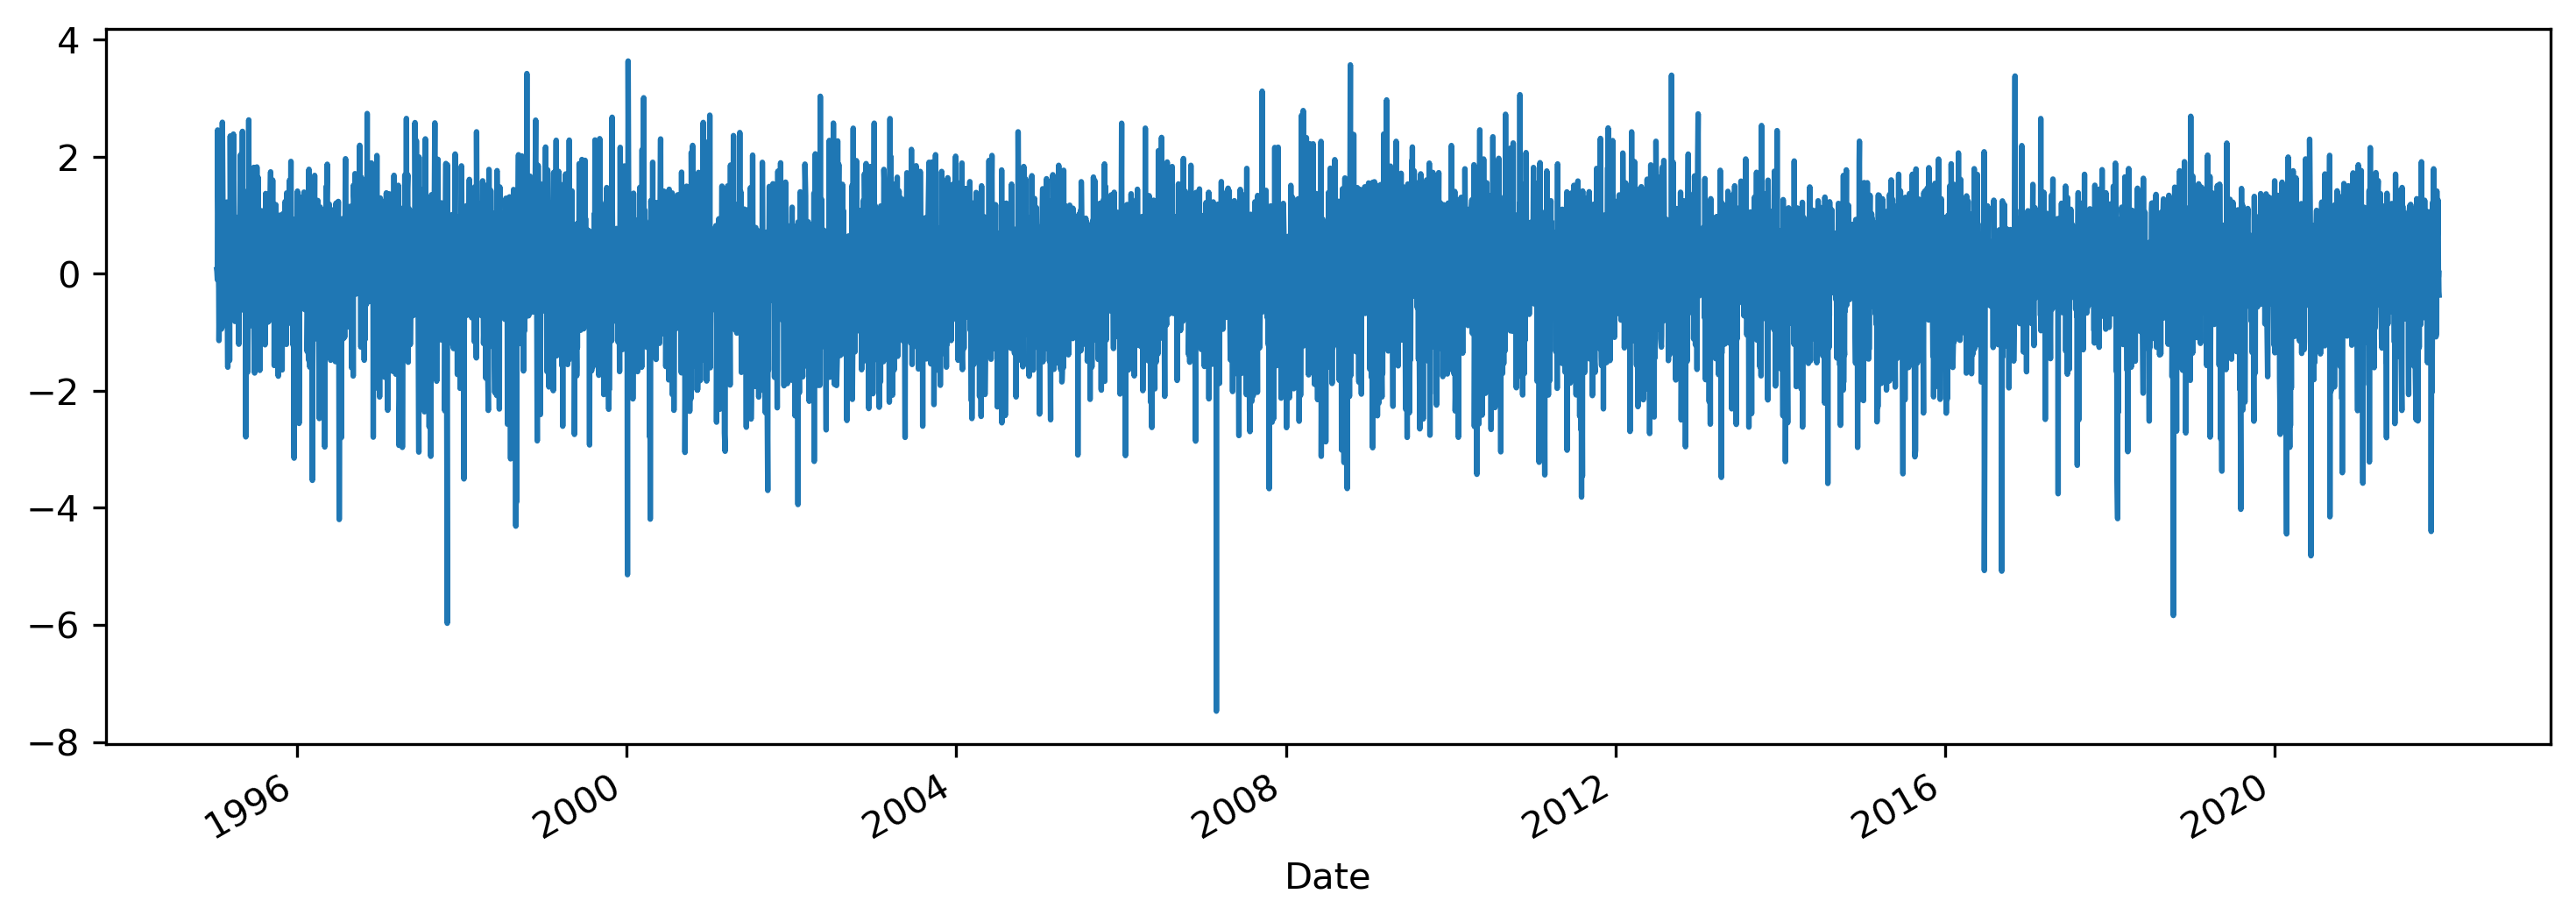

In [31]:
std_resid2 = res2.resid / res2.conditional_volatility

ax = std_resid2.plot(figsize=(12,4))

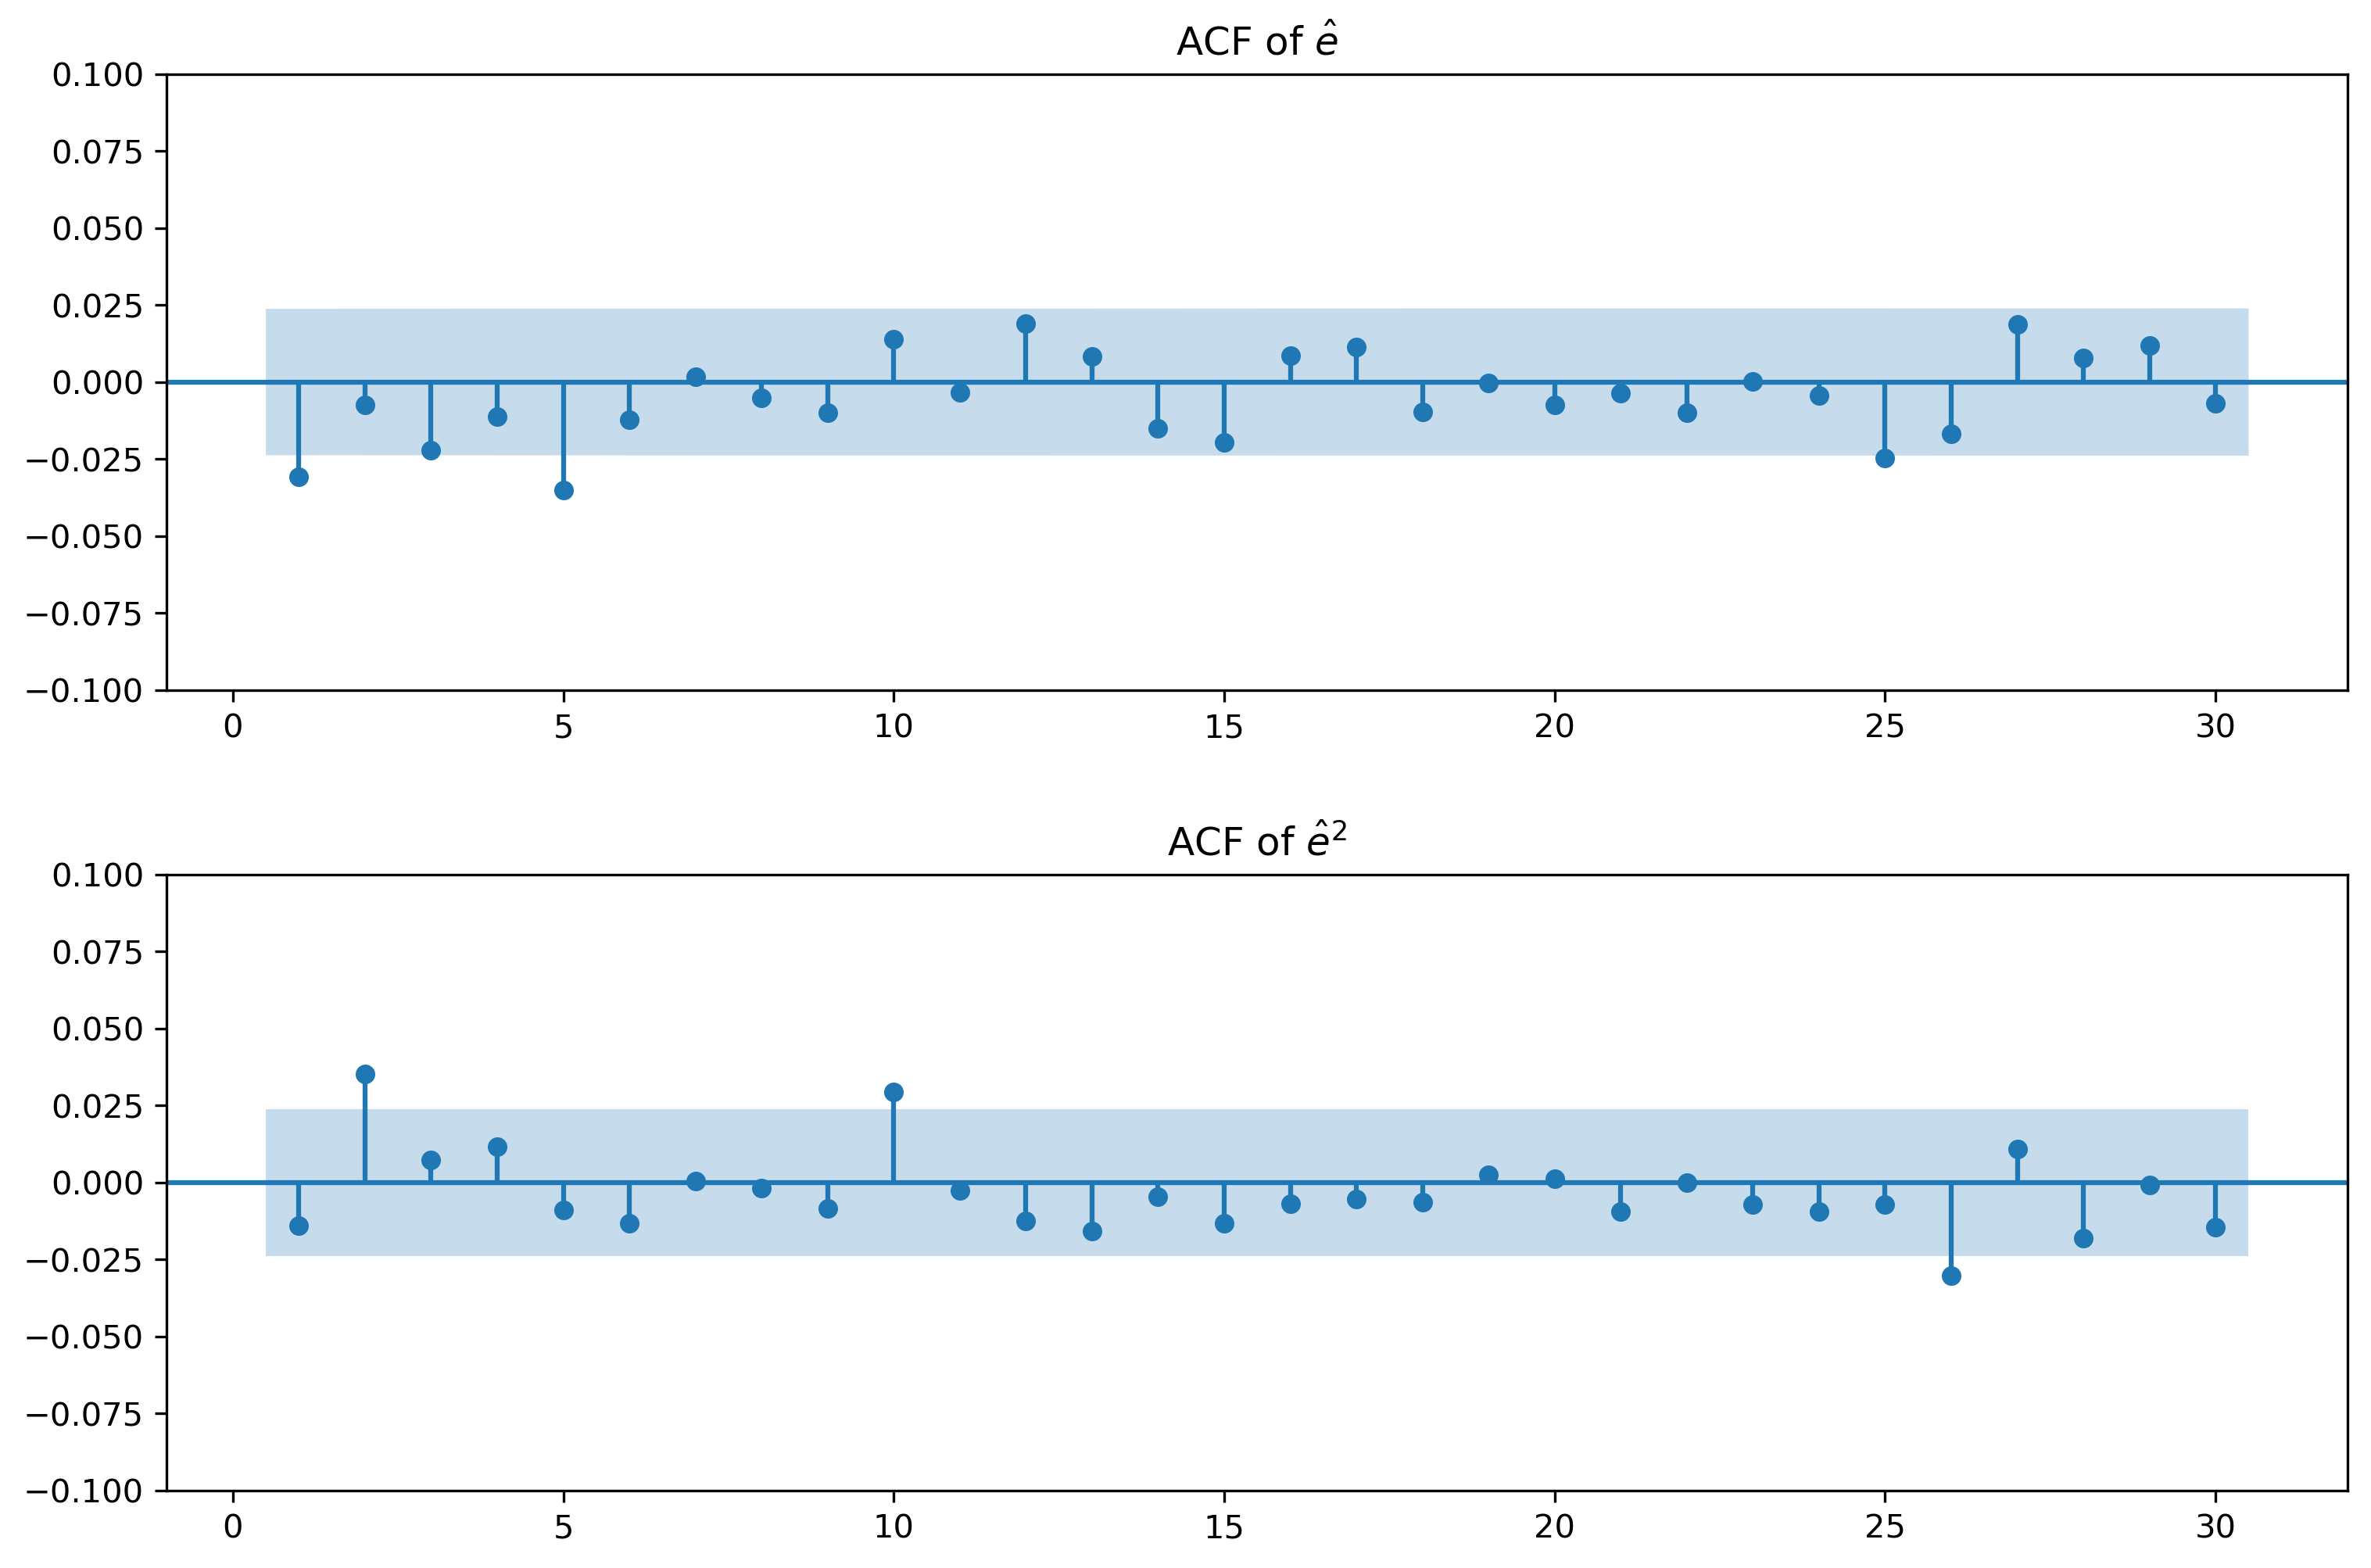

In [32]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(std_resid, lags=30, zero=False, auto_ylims=True, ax=ax1)
ax1.set_title('ACF of $\hat{e}$')
ax1.set_ylim(-0.1,.1)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(std_resid**2, lags=30, zero=False, auto_ylims=True, ax=ax2)
ax2.set_title('ACF of $\hat{e}^2$')
ax2.set_ylim(-0.1,.1)

plt.subplots_adjust(hspace=0.3)

plt.show()

In [37]:
acfn, qstats, pvals = acf(std_resid, qstat=True, nlags=30)

pvals

array([0.01088589, 0.03223421, 0.01681522, 0.02567064, 0.00156695,
       0.00225048, 0.00453889, 0.00797874, 0.01103002, 0.01190306,
       0.01897974, 0.01361292, 0.01844378, 0.01766818, 0.01221789,
       0.01595429, 0.01843343, 0.02231906, 0.03169609, 0.03998965,
       0.05311965, 0.06044416, 0.07929233, 0.09921871, 0.05257112,
       0.0450282 , 0.03486942, 0.04184343, 0.04443817, 0.05351798])

In [38]:
acf(std_resid**2, qstat=True, nlags=30)[2]

array([0.25122747, 0.00707337, 0.0170609 , 0.02337362, 0.03722292,
       0.04581681, 0.07634837, 0.11609946, 0.14545138, 0.03826229,
       0.05660476, 0.06758301, 0.06185944, 0.08462738, 0.08066328,
       0.09848987, 0.12286877, 0.14942988, 0.18870702, 0.23301418,
       0.2577372 , 0.30872018, 0.33929623, 0.36527916, 0.39712879,
       0.17860459, 0.18614917, 0.13817988, 0.16833678, 0.15657364])

## EGARCH

The EGARCH($p,q$) model specifies the log-volatility process as follows:

```{math}
:label: egarch_vol1
\ln\sigma _{{t}}^{2}=\omega +\sum _{{k=1}}^{{q}}\alpha_{{k}}g(e_{{t-k}})+\sum _{{k=1}}^{{p}}\beta_{{k}}\ln \sigma _{{t-k}}^{{2}},
```

where

$$g(e_t) := \theta e_t + \lambda \left[|e_t| - E(|e_t|)\right].$$

Modeling the log of volatility ensures that volatility is always positive, so no additional constraints are required. And the weighted error structure allows for an asymmetric effect of a return innovation on the volatility:

$$g(e_t) = 
\left\{\begin{matrix}
 (\theta+\lambda)e_t - \lambda E(|e_t|) & \quad \text{if } e_t\geq 0, \\ 
 (\theta-\lambda)e_t - \lambda E(|e_t|) & \quad \text{if } e_t< 0. \\ 
\end{matrix}\right.$$

That is, when an innovation $e_{t-k}$ is positive, log-variance increases by $\alpha_k(\theta+\lambda)$, but when the innovation is negative the log-variance decreases by $\alpha_k(\theta-\lambda)$. This asymmetry allows for a “leverage effect” as we'll soon see. (In either case, we also reduce the log-variance by $\lambda E(|e_t|)$, which we'll soon see is simply a number we can calculate.)

The `arch` package parameterizes the model as EGARCH($p,o,q$) with 

```{math}
:label: egarch_vol2
\ln\sigma_{t}^{2} = \omega +\sum_{k=1}^{p}\alpha_{k}\left(\left|e_{t-k}\right|-E(|e_t|)\right)
+\sum_{k=1}^{o}\gamma_{k} e_{t-k} +\sum_{k=1}^{q}\beta_{k}\ln\sigma_{t-k}^{2}.
```

Comparing {eq}`egarch_vol1` and {eq}`egarch_vol2`, we see that:

- implementing the typical EGARCH($p,q$) model implies that $p=o$;
- $\gamma_k$ maps to $\theta\alpha_k$ in equation (1); and
- $\alpha_k$ (in equation 2) maps to $\lambda\alpha_k$ in equation (1).

The $\gamma_k$ parameter is called the *leverage* parameter. If $\gamma_k=0$ then there is no asymmetry in the volaility — positive and negative values of $e_t$ have the same effect on $\sigma_t^2$. If, however, $\gamma<0$, then negative shocks will lead to larger increases in volatility than positive shocks.

### Error distributions

Three distributions are often used for the innovation $e_t$:

- the Normal distribution;
- the Student's T distribution; or
- the Generalized Error Distribution.

Each distributional assumption leads to a different value of $E(|e_{t}|)$. With a Normal distribution we have

$$E(|e_{t}|)=\sqrt{2/\pi}.$$

In [43]:
from scipy.stats import norm, t
from numpy import pi as π

In [ ]:
# calculate E(|e|) for e~N(0,1)

norm().expect(lambda x: np.abs(x))

0.7978845608028651

In [44]:
np.sqrt(2/π)

0.7978845608028654

With a Student's T distribution,

$$ E(|e_t|) = \frac{2\sqrt{\nu-2} \Gamma[(\nu+1)/2]}{(\nu-1) \Gamma(\nu/2)\sqrt{\pi}},$$

where $\Gamma(z)$ is the gamma function.

In [47]:
def exp_abs_e(ν):
    """Calculate E(|e_t|) for a Student's T distribution"""
    from scipy.special import gamma as Γ 
    return (2 * np.sqrt(ν-2) * Γ((ν+1)/2)) / ((ν-1) * Γ(ν/2) * np.sqrt(π))

In [48]:
df = 5

exp_abs_e(df)

0.7351051938957227

In [49]:
# standardized T-distribution
s = 1/np.sqrt(df/(df-2))
t_std = t(df=df, scale=s)

t_std.expect(lambda x: np.abs(x))

0.7351051938957227

The [Generalized Error Distribution](https://en.wikipedia.org/wiki/Generalized_normal_distribution#Version_1) is an alternative distribution that nests the Normal distribution, as well as several other continuous distributions.

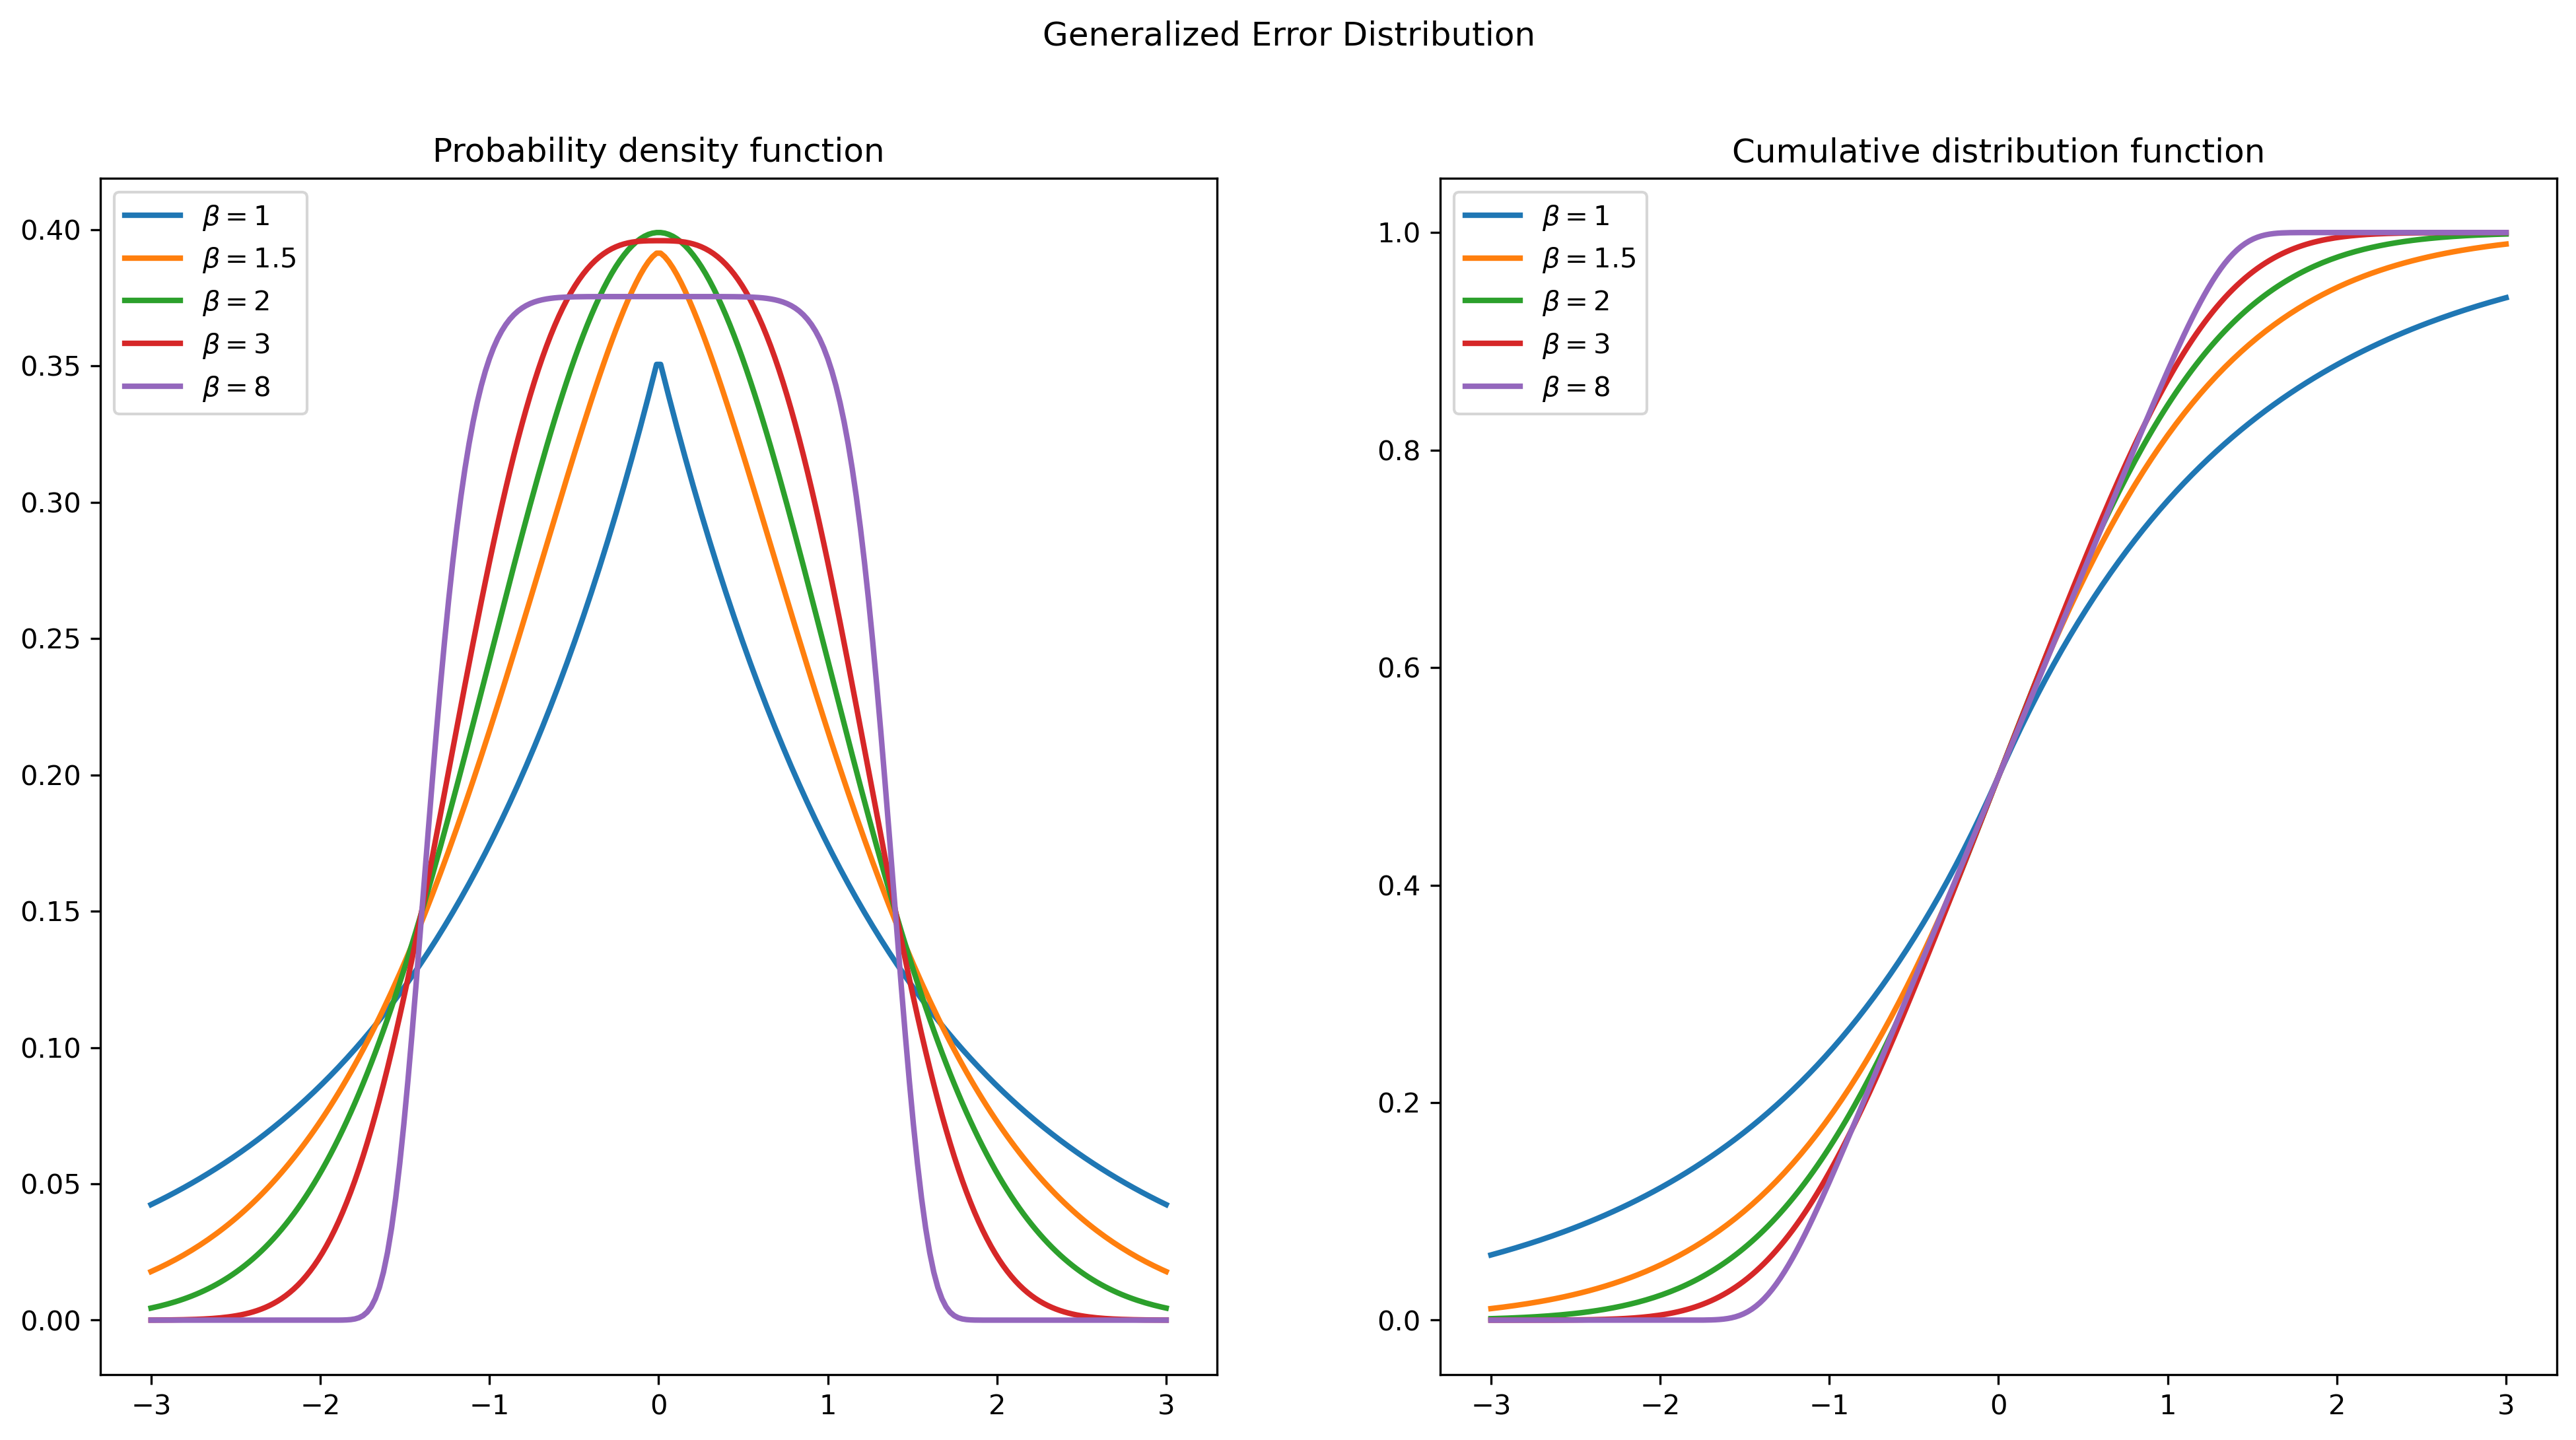

In [60]:
from scipy.stats import gennorm

x = np.linspace(-3, 3, 250)
s = np.sqrt(2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

for β in [1, 1.5, 2, 3, 8]:
    ax1.plot(x, gennorm.pdf(x, β, loc=0, scale=s), lw=2, label=r'$\beta={}$'.format(β))
    ax2.plot(x, gennorm.cdf(x, β, loc=0, scale=s), lw=2, label=r'$\beta={}$'.format(β))

ax1.legend(loc='upper left')
ax2.legend(loc='upper left')

fig.suptitle('Generalized Error Distribution')
ax1.set_title('Probability density function')
ax2.set_title('Cumulative distribution function')
    
plt.show()

### Estimation

In [50]:
mod3 = ARX(spy, lags=1)
mod3.volatility = EGARCH(1,1,1)
res3 = mod3.fit()
print(res3.summary())

Iteration:      1,   Func. Count:      8,   Neg. LLF: 23967397231135.21
Iteration:      2,   Func. Count:     20,   Neg. LLF: 366017986737545.5
Iteration:      3,   Func. Count:     31,   Neg. LLF: 24418148819768.273
Iteration:      4,   Func. Count:     42,   Neg. LLF: 324455003450.04645
Iteration:      5,   Func. Count:     53,   Neg. LLF: 22654209705255.023
Iteration:      6,   Func. Count:     64,   Neg. LLF: 29085.27547306702
Iteration:      7,   Func. Count:     74,   Neg. LLF: 9176.493053995988
Iteration:      8,   Func. Count:     82,   Neg. LLF: 9172.507298647359
Iteration:      9,   Func. Count:     89,   Neg. LLF: 9172.505306222632
Iteration:     10,   Func. Count:     96,   Neg. LLF: 9172.50525648429
Iteration:     11,   Func. Count:    103,   Neg. LLF: 9172.505250922835
Iteration:     12,   Func. Count:    109,   Neg. LLF: 9172.505250923823
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9172.505250922835
            Iterations: 12

In [51]:
mod4 = ARX(spy, lags=1)
mod4.volatility = EGARCH(2,2,2)
res4 = mod4.fit(disp='off')
print(res4.summary())

                          AR - EGARCH Model Results                           
Dep. Variable:                    ret   R-squared:                       0.005
Mean Model:                        AR   Adj. R-squared:                  0.005
Vol Model:                     EGARCH   Log-Likelihood:               -9160.71
Distribution:                  Normal   AIC:                           18339.4
Method:            Maximum Likelihood   BIC:                           18400.8
                                        No. Observations:                 6797
Date:                Mon, Apr 11 2022   Df Residuals:                     6795
Time:                        11:50:51   Df Model:                            2
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
Const          0.0481  9.882e-03      4.868  1.125e-

In [52]:
mod5 = ARX(spy, lags=1)
mod5.volatility = EGARCH(1,1,1)
mod5.distribution = StudentsT()
res5 = mod5.fit(disp='off')
print(res5.summary())

                             AR - EGARCH Model Results                              
Dep. Variable:                          ret   R-squared:                       0.005
Mean Model:                              AR   Adj. R-squared:                  0.005
Vol Model:                           EGARCH   Log-Likelihood:               -9018.93
Distribution:      Standardized Student's t   AIC:                           18051.9
Method:                  Maximum Likelihood   BIC:                           18099.6
                                              No. Observations:                 6797
Date:                      Mon, Apr 11 2022   Df Residuals:                     6795
Time:                              11:50:52   Df Model:                            2
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
-----------------------------------------------------------------------------

In [53]:
# for the log-variance equation
exp_abs_e(res5.params['nu'])

0.7562446836441398

## GJR-GARCH

Glosten, Jagannathan, and Runkle (1993) develop another model that allows asymmetric effects on volatility, which became known as GJR-GARCH. They specify the following process for the variance:

$$\sigma^2_t  =  \omega + \alpha \varepsilon_{t-1}^2 + \gamma \varepsilon_{t-1}^2 I\{\varepsilon_{t-1}<0\}+ \beta \sigma_{t-1}^2 $$

where $I\{\cdot\}$ is an *indicator variable* that equals one when the condition it evaluates is true, and zero otherwise.

In [55]:
mod6 = ARX(spy, lags=1)
mod6.volatility = GARCH(p=1,o=1,q=1)
res6 = mod6.fit(disp='off')
print(res6.summary())

                         AR - GJR-GARCH Model Results                         
Dep. Variable:                    ret   R-squared:                       0.005
Mean Model:                        AR   Adj. R-squared:                  0.005
Vol Model:                  GJR-GARCH   Log-Likelihood:               -9200.06
Distribution:                  Normal   AIC:                           18412.1
Method:            Maximum Likelihood   BIC:                           18453.1
                                        No. Observations:                 6797
Date:                Mon, Apr 11 2022   Df Residuals:                     6795
Time:                        11:51:49   Df Model:                            2
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
Const          0.0486  9.700e-03      5.014  5.341e-

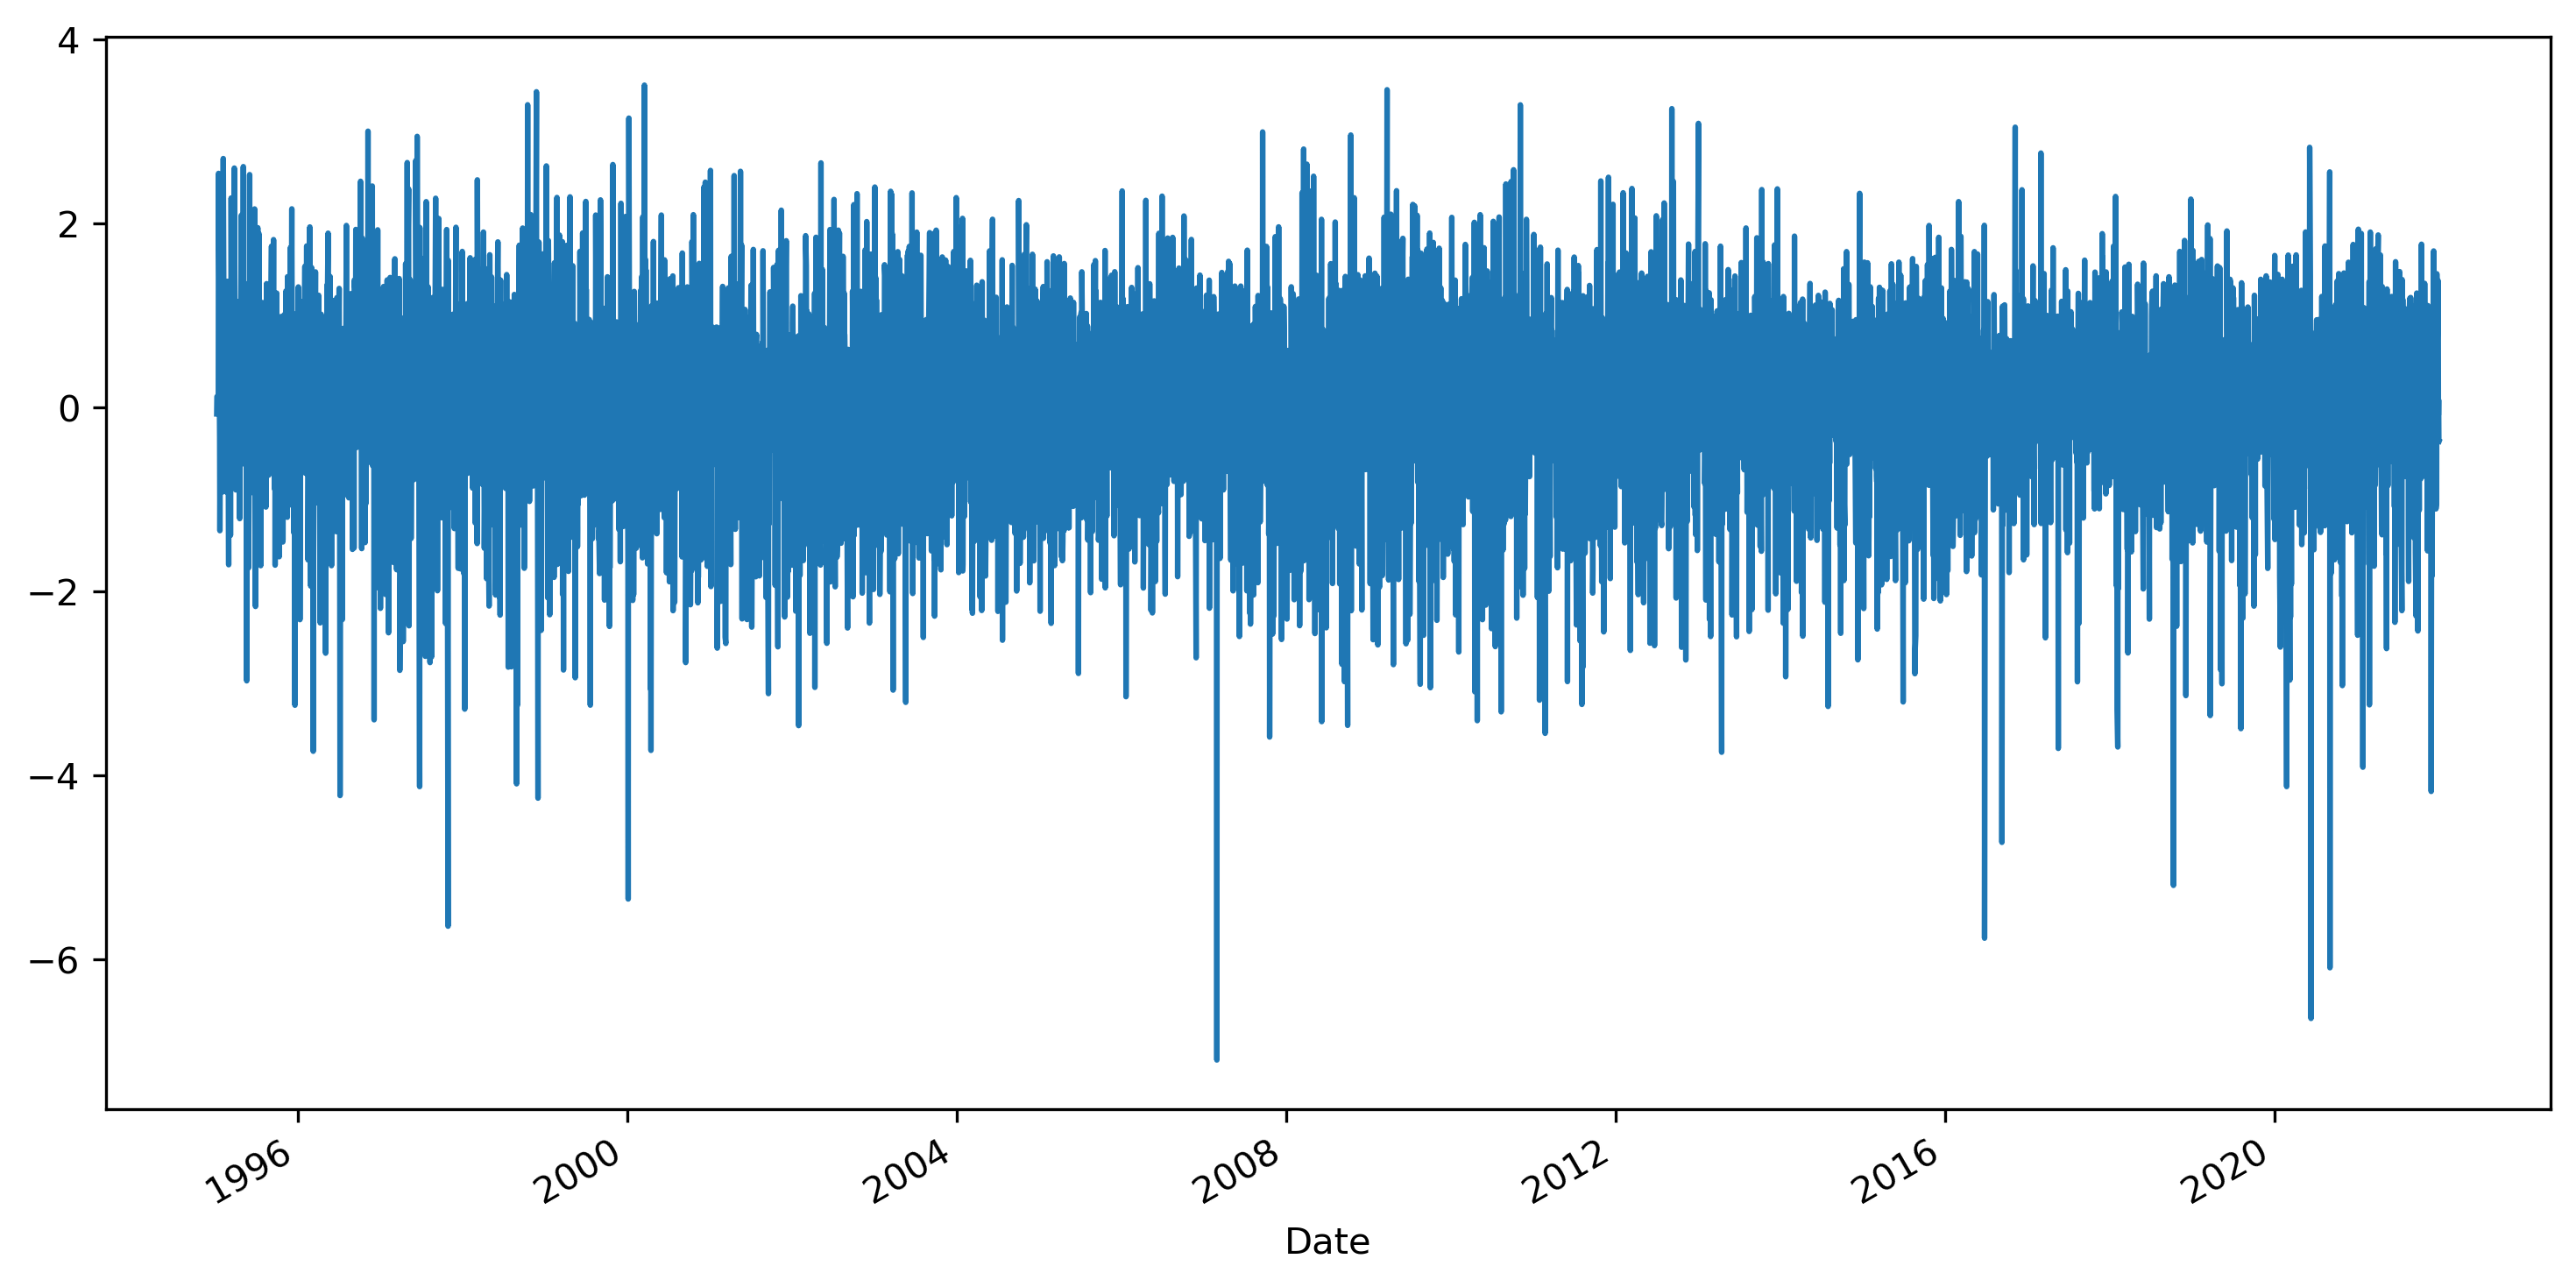

In [56]:
res6.std_resid.plot();

## TARCH

The Threshold Autoregressive Conditional Heteroskedasticity model uses an indicator variable as in GJR–GARCH but also models the volatility using the absolute value of the innovations rather than modeling variance with the squares:

$$
\sigma_t  =  \omega + \alpha \left|\varepsilon_{t-1}\right| + \gamma \left|\varepsilon_{t-1}\right| I\{\varepsilon_{t-1}<0\}+ \beta \sigma_{t-1}.
$$

This is implemented by specifying a `power` variable of 1, rather than the default value of 2.

In [57]:
mod7 = ARX(spy, lags=1)
mod7.volatility = GARCH(1,1,1,power=1)
res7 = mod7.fit(disp='off')
print(res7.summary())

                        AR - TARCH/ZARCH Model Results                        
Dep. Variable:                    ret   R-squared:                       0.005
Mean Model:                        AR   Adj. R-squared:                  0.005
Vol Model:                TARCH/ZARCH   Log-Likelihood:               -9153.01
Distribution:                  Normal   AIC:                           18318.0
Method:            Maximum Likelihood   BIC:                           18359.0
                                        No. Observations:                 6797
Date:                Mon, Apr 11 2022   Df Residuals:                     6795
Time:                        11:51:57   Df Model:                            2
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const          0.0436  5.458e-03      7.984  1.415e-15 

More general models can be obtained by specifying different values for the power, $k$:

$$
\sigma_t^\kappa   = \omega + \alpha \left|\varepsilon_{t-1}\right|^\kappa + \gamma \left|\varepsilon_{t-1}\right|^\kappa I_{[\varepsilon_{t-1}<0]}+ \beta \sigma_{t-1}^\kappa.
$$